In [1]:
%pylab inline
import os
import pandas as pd
import numpy as np
import sys



from sklearn.preprocessing import LabelBinarizer
import imgaug as ia
import imgaug.augmenters as iaa
import random
import cv2
from matplotlib import pyplot as plt
import glob
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras import optimizers

PARENT_DIR = os.path.dirname(os.getcwd())
sys.path.insert(1, PARENT_DIR+"\\scripts")
import utilities

PARENT_DIR

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


'D:\\DS_projects\\yptek_cv'

In [2]:
DATA_DIR = PARENT_DIR + "\\data\\"
OUT_DIR = PARENT_DIR + "\\output\\"
DEBUG_MOD = True # False #
MODEL_NAME = OUT_DIR + "model_part1.h5"

In [3]:
images_file_name = OUT_DIR + "images.pkl"
labels_file_name = OUT_DIR + "labels.pkl"

test_img_file_name = OUT_DIR + "test_img.pkl"
test_lbl_file_name = OUT_DIR + "test_lbl.pkl"

# parsing image

In [4]:
if not os.path.isfile(images_file_name):
    print("parsing images")
    # train data
    folder_path = DATA_DIR+"train"
    x_data, y_data = utilities.parse_files(folder_path, images_file_name, labels_file_name)
     # testing and error analysis
    folder_path = DATA_DIR+"test"
    x_test, y_test = utilities.parse_files(folder_path, test_img_file_name, test_lbl_file_name)
else:
    print("loading images")
    x_data, y_data = utilities.read_data(images_file_name, labels_file_name)
    x_test, y_test = utilities.read_data(test_img_file_name, test_lbl_file_name)

loading images


## checking data parsing done well

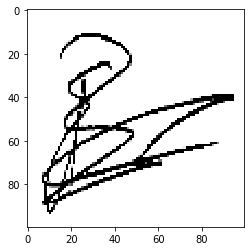

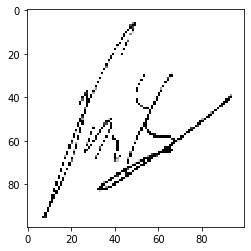

In [5]:
# check whether parsed data stored properly  
plt.imshow(x_data[0][:,:,0], cmap='gray',clim=(0,1))
plt.show()
plt.imshow(x_test[0][:,:,0], cmap='gray',clim=(0,1))
plt.show()

In [6]:
## train validation seperation

In [7]:
# train validation seperation
x_train, x_val, y_train, y_val, n_class = utilities.seperate_train_validation_data(x_data, y_data)

number of data for each class: [[ 1 12]
 [ 2 12]
 [ 3 12]
 [ 4 12]
 [ 6 12]
 [ 7 12]
 [ 8 12]
 [ 9 11]
 [10 12]
 [11 12]
 [12 12]
 [14 12]
 [15 12]
 [16 12]
 [17 12]
 [18  6]
 [19 12]
 [20 12]
 [21 12]
 [22 12]
 [23 12]
 [24 12]
 [26 12]
 [27 12]
 [28 12]
 [29 12]
 [30 12]
 [31 12]
 [33 12]
 [35 12]
 [37 12]
 [39 12]
 [41 12]
 [42 12]
 [43 12]
 [44 12]
 [45 12]
 [46 12]
 [47 12]
 [49 12]
 [51 12]
 [53 12]
 [54 12]
 [55 11]
 [56 12]
 [58 12]
 [59 12]
 [62 12]
 [63 12]
 [64 12]
 [66 12]
 [67 12]
 [68 12]
 [69 12]
 [70 12]
 [71 12]
 [72 12]
 [73 12]
 [74 12]
 [75 12]
 [77 12]
 [79 12]]
unique labels [ 1  2  3  4  6  7  8  9 10 11 12 14 15 16 17 18 19 20 21 22 23 24 26 27
 28 29 30 31 33 35 37 39 41 42 43 44 45 46 47 49 51 53 54 55 56 58 59 62
 63 64 66 67 68 69 70 71 72 73 74 75 77 79]
n_class: 79


# Build model
## Design of model
Our Architecture is as follows:

conv => max pool => dropout => conv => max pool => dropout => fully connected => fully connected

But depending on the performance, this architecture was changed and hyperparameter tuning was also done.


since there are more than 2 classes to detect, categorical cross_entropy is used as loss function whose equation is below:
![cce](cce.png)

**Activation functions:** are selected as ReLU in order to cancel out vanishing gradient and provide non linearity to model. But the last Dense layer activation must be chosen as softmax because its normalized form of values so, it can be said that it also shows the probability of each class to be.  

there are also other criterias for multi class classification


* optimizer : adam, RMSprop and SGD after all trials 
    * SGD: best val_accuracy =  0.67656
    * adam: best val_accuracy =  0.8649
    * RMSprop: best val_accuracy =  0.93541
    
## Fine tuning
there are two options for hyper tuning
* reduce fixed image size
* reduce filter number

initially fixed_img_size = (200,200)
filter number first conv =  64
filter number first conv =  128

after many trials best conf
initially fixed_img_size = (100,100)
filter number first conv =  4
filter number first conv =  8

MODEL_NAME = OUT_DIR + "cnn_model.h5"
b_build_model =  False # True #
if b_build_model:
    model = utilities.build_and_fit_cnn_model(x_train, y_train, x_val,y_val, n_class, MODEL_NAME)
else:
    img_shape = x_train[0].shape
    model, call_backs = utilities.initialize_cnn_model(img_shape, n_class, MODEL_NAME)

# Transfer Learning

## convert 1d grayscale into 3d 

inception model accepts only rgb image, therefore grayscale images must be converted into 3d 

In [8]:
(x_train, y_train, x_val,y_val, n_class, MODEL_NAME)

x_train_rgb = np.zeros((x_train.shape[0],x_train.shape[1],x_train.shape[2],3))
x_val_rgb = np.zeros((x_val.shape[0],x_val.shape[1],x_val.shape[2],3))
x_test_val = np.zeros((x_test.shape[0],x_test.shape[1],x_test.shape[2],3))

img_shape_rgb = x_train_rgb.shape[1:]

In [13]:
import tensorflow as tf
# loading Inception

modl_inceptn = tf.keras.applications.MobileNet(include_top=False, weights="imagenet", input_shape=img_shape_rgb)
modl_inceptn.summary()

17227776/17225924 [==============================] - 19s 1us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 101, 101, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 50, 50, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 50, 50, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 50, 50, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 50, 50, 32)        288       
________________________________________________

In [18]:
# freezing layers
for layer in modl_inceptn.layers:
    layer.trainable=False
# getting mixed7 layer
l = modl_inceptn.get_layer("conv_pw_12_bn")

## create our customized model from v3 inception bone

In [21]:
def set_keras_callback(MODEL_NAME):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, \
                                   verbose=1, mode='auto', restore_best_weights=True)

    mcp_save = tf.keras.callbacks.ModelCheckpoint(MODEL_NAME, save_best_only=True, save_weights_only=True, \
                               monitor='val_accuracy', mode='auto', verbose=1)

    learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                patience=3,
                                                verbose=1,
                                                factor=0.5,
                                                min_lr=0.00001)
    call_backs = [early_stopping, mcp_save, learning_rate_reduction]
    return call_backs

In [25]:
epochs = 100 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 128

#x = tf.keras.layers.Flatten()(l.output)
x = tf.keras.layers.Dropout(.5)(x)  
#x = tf.keras.layers.Dense(128, activation='relu')(x)             
x = tf.keras.layers.Dense(n_class, activation='sigmoid')(x)           
model = tf.keras.Model(modl_inceptn.input, x)

call_backs = set_keras_callback(MODEL_NAME)

# Define the optimizer
optimizer = tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# multi class prediction use categorical_crossentropy as loss accuracy as metrics
model.compile(optimizer="RMSprop", loss="categorical_crossentropy", metrics=["accuracy"])
print(model.summary())
if os.path.isfile(MODEL_NAME):
    print("loading weights")
    model.load_weights(MODEL_NAME)
history = model.fit(x_train_rgb,y_train, batch_size=batch_size,\
          epochs = epochs, validation_data = (x_val_rgb,y_val),\
          verbose = 2, callbacks=call_backs)
#plot accuracy and loss
utilities.draw_accuracy_loss_plot(history)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 101, 101, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 50, 50, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 50, 50, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 50, 50, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 50, 50, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 50, 50, 32)        128 

ValueError: You are trying to load a weight file containing 52 layers into a model with 53 layers.

In [ ]:
# Predict the values from the validation dataset
y_pred = model.predict(x_test)

df = pd.DataFrame(y_pred)
df["y_test"] = y_test
df


## feature generation from this probabilities

In [ ]:
from scipy import sparse

from sklearn.decomposition import PCA

A =  df.iloc[:,:-1].values
pca = PCA(n_components=4)

A_red = pca.fit_transform(A) #sparse.csr_matrix()
A_red

In [ ]:
cum_result_df = utilities.calculate_similarity_table(A_red, y_test)
cum_result_df.to_csv("similarity_table.csv")
cum_result_df.head(12)

In [ ]:
threshold = 0.9
result = utilities.similarity_prediction(cum_result_df, threshold)
result["gr_truth"] = result["gr_truth"].astype(int)
result["pred"] = result["pred"].astype(int)
result.head(24)

In [ ]:
utilities.plot_roc_curve(result)




In [ ]:
from sklearn.metrics import precision_recall_curve, f1_score, auc
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(result["gr_truth"], result["score"])
f1, auc = f1_score(result["gr_truth"], result["pred"]), auc(recall, precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
testy = result["gr_truth"].values
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

# Cocnlusion
as seen in precision-recal and ROC curve analysis, best threshold is 0.97. furthermore, it is also suitable for fraud case since the system precision is quite high and secure to run on real operations

# Confusion Matrix

In [ ]:
# compute the confusion matrix
confusion_mtx = confusion_matrix(result["gr_truth"], result["pred"]) 
# plot the confusion matrix
utilities.plot_confusion_matrix(confusion_mtx, classes = range(2)) 

# Classification Report (precision, recall and f1 score)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_true, Y_pred_classes))

In [ ]:
# Display some error results 
img_shape = X_data[0].shape[:2]
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]


# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_delta_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_delta_errors[-6:]

# Show the top 6 errors
utilities.display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors, img_shape)

as you can see above, the most erronous detection in the class which train data of them are not informative, some of them are not similar to corresponding class images.

# Conclusion
As seen in **Classification Report (precision, recall and f1 score) and confusion matrix**, this model has good performance generally, therefore, there is no need to optimize and **hyperparameter tuning**. These hyper parameters are initialized by my initial standard values out of my huge experience in cnn  but, there is some lower performances in some classes. it can be improved this classes after a comprehensive investigation. it can also show the which classes and pictures the model made the most error to understand the model characteristics.. then generally, data augmneation and weighted loss functions cab applied to increase the perfromace of them. 